# Prediction of true news

## Imports

In [2]:
import re
import time
from joblib import dump, load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.sparse import issparse

import nltk
import pymorphy2
from nltk.corpus import stopwords

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid

nltk.download('stopwords', quiet=True)
pd.set_option('display.max_columns', None);

## Read data

In [3]:
train = pd.read_csv('data/train.csv', sep='\t')
test = pd.read_csv('data/test.csv', sep='\t')
train.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


## View data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [6]:
train["is_fake"].value_counts()

is_fake
1    2879
0    2879
Name: count, dtype: int64

In [7]:
test["is_fake"].value_counts()

is_fake
0    1000
Name: count, dtype: int64

## Checking for possible additional feature in training

Признаки выбраны как простые текстовые метрики, отражающие стилистику заголовков, часто ассоциируемую с фейковыми новостями: длина, пунктуация, заглавные буквы, цифры и длина слов.

In [8]:
def extract_features(df):
    return pd.DataFrame({
        'len': df['title'].str.len(),
        'num_punctuation': df['title'].str.count('[:,.!?]'),
        'num_upper': df['title'].str.count(r'[A-ZА-Я]'),
        'num_digits': df['title'].str.count(r'\d'),
        'mean_word_len': df['title'].apply(lambda x: np.mean([len(w) for w in x.split()])),
        'is_fake': df["is_fake"]
    })

add_features = extract_features(train)
add_features["has_digits"] = (add_features["num_digits"] > 0).astype(int)

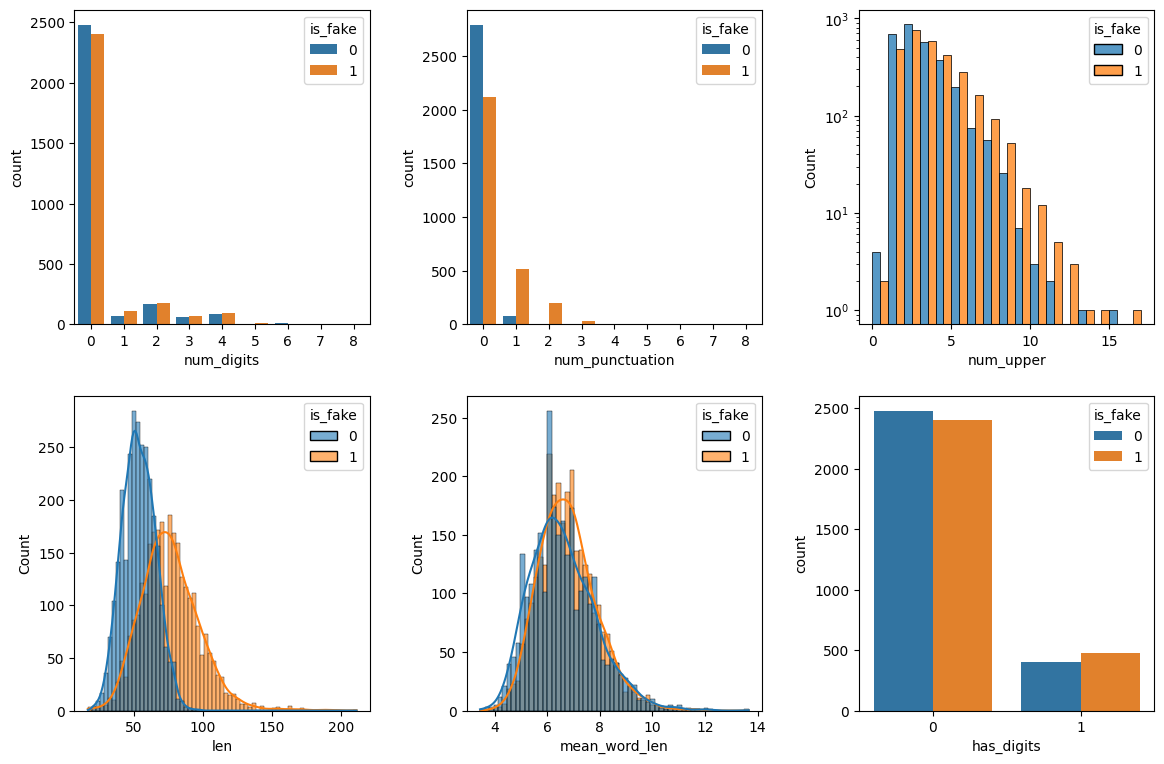

In [9]:
plt.figure(figsize=(12, 8))

plt.subplot(231)
sns.countplot(data=add_features, x='num_digits', hue='is_fake')

plt.subplot(232)
sns.countplot(add_features, x="num_punctuation", hue="is_fake")

plt.subplot(233)
plt.yscale('log')
sns.histplot(data=add_features, x='num_upper', hue='is_fake', multiple='dodge', binwidth=1)

plt.subplot(234)
sns.histplot(add_features, x="len", hue="is_fake", alpha=0.6, kde=True)

plt.subplot(235)
sns.histplot(add_features, x="mean_word_len", hue="is_fake", alpha=0.6, kde=True);

plt.subplot(236)
sns.countplot(data=add_features, x='has_digits', hue='is_fake')

plt.tight_layout(pad=2.0);


**Из визуализации этих признаков я решил оставить в качестве дополнительных признаков только num_punctuation, num_upper и len.**


## Preprocessing

In [78]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, lemmatize_flag=True):
        self.lemmatize_flag = lemmatize_flag
        self.russian_stopwords = set(stopwords.words("russian"))
        self.morph = pymorphy2.MorphAnalyzer() if lemmatize_flag else None
        
    def _lemmatize(self, word):
        if not self.lemmatize_flag or not self.morph:
            return word
        parsed = self.morph.parse(word)
        return parsed[0].normal_form if parsed else word
        
    def _preprocess_text(self, text):
        text = text.lower()
        words = re.findall(r"\w+", text)
        words = [self._lemmatize(word) for word in words if word not in self.russian_stopwords]
        return " ".join(words) if words else "empty"
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame({   
                col: X[col].apply(self._preprocess_text) for col in X.columns
            })
        else:
            return pd.Series(X).apply(self._preprocess_text)

In [136]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, features_names=["dummy_feature"]):
        self.features_names = features_names

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.Series):
            column = X
        elif isinstance(X, pd.DataFrame):
            column = X.iloc[:, 0]
        else:
            column = pd.Series(X)
        
        futures = pd.DataFrame({
            'len': column.str.len(),
            'num_punctuation': column.str.count('[:,.!?]'),
            'num_upper': column.str.count(r'[A-ZА-Я]'),
            'dummy_feature': [0] * len(X)
        })

        return futures[self.features_names]


In [137]:
def get_features_names_out(preprocessor):
    tfidf_features = preprocessor.named_transformers_['tfidf'].get_feature_names_out()
    feature_extractor_names = preprocessor.named_transformers_['features'].named_steps['featureextractor'].features_names
    all_feature_names = np.concatenate([tfidf_features, feature_extractor_names])
    return all_feature_names

In [138]:
features_pipeline = make_pipeline(
    FeatureExtractor(),
    StandardScaler()
)

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(), 'title'),  
    ('features', features_pipeline, 'title')  
])

In [209]:
y = train["is_fake"]
X = pd.DataFrame(train["title"], columns=["title"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

На этом этапе был создан препроцессор, который:
1. Добавляет новые столбцы: в данном случае `len`, `num_punctuation`, `num_upper`.
2. Применяет `StandardScaler` к этим столбцам.
3. Применяет `TfidfVectorizer` к столбцу `title`.

Также была создана функция `get_features_names_out` для удобного получения названий признаков.

## Baseline Model

In [140]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])

In [141]:
pipe.fit(X_train, y_train)
features_names = get_features_names_out(pipe["preprocessor"])

In [142]:
y_pred = pipe.predict(X_val)

In [143]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       576
           1       0.81      0.83      0.82       576

    accuracy                           0.82      1152
   macro avg       0.82      0.82      0.82      1152
weighted avg       0.82      0.82      0.82      1152



## Search best model and params

In [146]:
class SearchProc:
    """
    Класс SearchProc выполняет:

    1. Поиск гиперпараметров с RandomizedSearchCV (self.fit_search_model)
    2. Обучение модели с лучшими параметрами (self.fit_best_model)
    3. Оценку качества (self.evaluate_model)
    4. Вывод лучших параметров (self.print_search_results)
    5. Вывод важнейших признаков (self.print_top_features)

    при запуске метода self.run_proc()
    """

    def __init__(self, model_class, param_grid, preprocessor, n_iter=100, scoring="f1", verbose=0):
        self.model_class = model_class
        self.param_grid = param_grid

        self.model = None
        self.search_model = None

        self.n_params = len(list(ParameterGrid(self.param_grid)))
        self.n_iter = n_iter if n_iter < self.n_params else self.n_params
        self.scoring = scoring
        self.verbose = verbose

        self.preprocessor = preprocessor

    def _create_pipeline(self):
        return Pipeline([
            ('preprocessor', self.preprocessor),
            ('model', self.model_class())
        ])
        
    def _get_features_names_out(self, preprocessor):
        """Использована внешняя функция"""
        return np.array(get_features_names_out(preprocessor))

    def fit_search_model(self, X_train, y_train):
        print(f"Starting hyperparameter search ({self.n_iter} params)...")
        start_time = time.time()

        estimator = self._create_pipeline()
        self.search_model = RandomizedSearchCV(
            estimator,
            self.param_grid,
            n_iter=self.n_iter,
            cv=5,
            n_jobs=-1,
            verbose=self.verbose,
            scoring=self.scoring
        )

        self.search_model.fit(X_train, y_train)
        elapsed = time.time() - start_time
        print(f"Hyperparameter search completed in {elapsed:.2f} seconds\n")

    def fit_best_model(self, X_train, y_train):
        print("Training best model...")
        start_time = time.time()

        best_params = self.search_model.best_params_
        self.model = self._create_pipeline()
        self.model.set_params(**best_params)
        self.model.fit(X_train, y_train)

        elapsed = time.time() - start_time
        print(f"Best model trained in {elapsed:.2f} seconds\n")

    def evaluate_model(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        print(classification_report(y_test, y_pred), "\n")

    def print_search_results(self, top_n=3):
        cv_results = (
            pd.DataFrame(self.search_model.cv_results_)
            .sort_values("mean_test_score", ascending=False)
            [["mean_fit_time", "params", "mean_test_score"]]
            .round({
                "mean_fit_time": 2,
                "mean_test_score": 4,
                "std_test_score": 4
            })
        )[:top_n]
        cv_results["params"] = cv_results["params"].apply(
            lambda x: "\n".join(f"{k}: {v}" for k, v in x.items())
        )

        print(f"Top {top_n} combinations:")
        print(tabulate(
            cv_results,
            headers=cv_results.columns,
            tablefmt="grid",
            stralign="left",
            numalign="center",
            showindex=False
        ))
        print()

    def print_top_features(self, top_n=5):
        model = self.model["model"]

        if not hasattr(model, 'feature_importances_') and not hasattr(model, 'coef_'):
            print("This model does not support feature importance extraction.")
            return

        features_names = self._get_features_names_out(self.preprocessor)

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
        
        if issparse(importances):
            importances = importances.toarray().flatten()

        print(f"Top {top_n} most important features:")
        indices = np.argsort(np.abs(importances))[::-1][:top_n]
        max_word_len = max(len(features_names[i]) for i in indices)
        for i in indices:
            print(f"{features_names[i]:<{max_word_len}} : {importances[i]:+.4f}")

    def run_proc(self, X_train, X_test, y_train, y_test):
        self.fit_search_model(X_train, y_train)
        self.fit_best_model(X_train, y_train)
        self.evaluate_model(X_test, y_test)
        self.print_search_results()
        self.print_top_features()

### LogisticRegression

In [162]:
general = {
    'preprocessor__features__featureextractor__features_names' :
    [   
        ['dummy_feature'],
        ['len'],
        ['len', 'num_punctuation'],
        ['len', 'num_punctuation', 'num_upper']
    ]
}

param_grid_lr = {
    'model__solver': ['saga'],
    'model__penalty': ['l1', 'l2'],
    'model__max_iter': [100000],
    "model__C": [0.001, 0.01, 0.1, 1, 10],
    'model__n_jobs': [-1],
    **general
}

In [163]:
proc_lr = SearchProc(
    LogisticRegression,
    param_grid_lr,
    preprocessor,
    n_iter=50,
    scoring="f1",
    verbose=10
)

proc_lr.run_proc(X_train, X_val, y_train, y_val)

Starting hyperparameter search (40 params)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START model__C=0.001, model__max_iter=100000, model__n_jobs=-1, model__penalty=l1, model__solver=saga, preprocessor__features__featureextractor__features_names=['dummy_feature']
[CV 3/5; 1/40] START model__C=0.001, model__max_iter=100000, model__n_jobs=-1, model__penalty=l1, model__solver=saga, preprocessor__features__featureextractor__features_names=['dummy_feature']
[CV 2/5; 1/40] START model__C=0.001, model__max_iter=100000, model__n_jobs=-1, model__penalty=l1, model__solver=saga, preprocessor__features__featureextractor__features_names=['dummy_feature']
[CV 3/5; 2/40] START model__C=0.001, model__max_iter=100000, model__n_jobs=-1, model__penalty=l1, model__solver=saga, preprocessor__features__featureextractor__features_names=['len']
[CV 1/5; 2/40] START model__C=0.001, model__max_iter=100000, model__n_jobs=-1, model__penalty=l1, model__solver=saga, preprocessor

### SVC

In [164]:
param_grid_svc = [
    {
        **general,
        'model__kernel': ['linear'], 
        'model__C': [0.1, 1, 10],
        'model__probability': [True]
    },
    {
        **general,
        'model__kernel': ['poly', 'rbf', 'sigmoid'],    
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 0.01],
        'model__probability': [True]
    },
    
]

In [165]:
proc_svc = SearchProc(
    SVC,
    param_grid_svc,
    preprocessor,
    n_iter=150,
    scoring="f1"
)

proc_svc.run_proc(X_train, X_val, y_train, y_val)

Starting hyperparameter search (84 params)...
Hyperparameter search completed in 260.22 seconds

Training best model...
Best model trained in 4.29 seconds

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       576
           1       0.90      0.85      0.88       576

    accuracy                           0.88      1152
   macro avg       0.88      0.88      0.88      1152
weighted avg       0.88      0.88      0.88      1152
 

Top 3 combinations:
+-----------------+---------------------------------------------------------------------------------------------------+-------------------+
|  mean_fit_time  | params                                                                                            |  mean_test_score  |
+=================+===================================================================================================+===================+
|       5.7       | preprocessor__features__featureextractor__features_name

### GradientBoostingClassifier

In [166]:
param_grid_gb = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5],
    'model__max_features': ['sqrt', 'log2'],
    **general
}

In [173]:
proc_gb = SearchProc(
    GradientBoostingClassifier,
    param_grid_gb,
    preprocessor,
    n_iter=500,
    scoring="f1"
)

proc_gb.run_proc(X_train, X_val, y_train, y_val)

Starting hyperparameter search (432 params)...
Hyperparameter search completed in 72.63 seconds

Training best model...
Best model trained in 0.31 seconds

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       576
           1       0.86      0.78      0.82       576

    accuracy                           0.83      1152
   macro avg       0.83      0.83      0.83      1152
weighted avg       0.83      0.83      0.83      1152
 

Top 3 combinations:
+-----------------+--------------------------------------------------------------------------------------+-------------------+
|  mean_fit_time  | params                                                                               |  mean_test_score  |
+=================+======================================================================================+===================+
|       0.4       | preprocessor__features__featureextractor__features_names: ['len', 'num_punctuation'] |      0.

### RandomForestClassifier

In [174]:
param_grid_rf = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__max_depth': [10, 20, 30, 40, 70],
    'model__max_features': ['sqrt', 'log2'],
    'model__n_jobs': [-1],
    **general
}

In [175]:
proc_rf = SearchProc(
    RandomForestClassifier,
    param_grid_rf ,
    preprocessor,
    n_iter=500,
    scoring="f1"
)

proc_rf.run_proc(X_train, X_val, y_train, y_val)

Starting hyperparameter search (160 params)...
Hyperparameter search completed in 55.31 seconds

Training best model...
Best model trained in 0.30 seconds

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       576
           1       0.89      0.74      0.81       576

    accuracy                           0.82      1152
   macro avg       0.83      0.82      0.82      1152
weighted avg       0.83      0.82      0.82      1152
 

Top 3 combinations:
+-----------------+---------------------------------------------------------------------------------------------------+-------------------+
|  mean_fit_time  | params                                                                                            |  mean_test_score  |
+=================+===================================================================================================+===================+
|      1.18       | preprocessor__features__featureextractor__features_name

### Search results for the best parameters and models

In [219]:
print("Best f1 score: ")
print(f"lr: {round(float(proc_lr.search_model.best_score_), 4)}")
print(f"svc: {round(float(proc_svc.search_model.best_score_), 4)}")
print(f"rf: {round(float(proc_rf.search_model.best_score_), 4)}")
print(f"gb: {round(float(proc_gb.search_model.best_score_), 4)}")

Best f1 score: 
lr: 0.8584
svc: 0.8624
rf: 0.7935
gb: 0.8151


In [221]:
def print_hyperparameter(params, label):
    print(label)
    for k, v in params.items():
        print(f"hyperparameter {k} = {v}")
    print()


print("Best Hyperparameters: \n")
print_hyperparameter(proc_lr.search_model.best_params_, "lr:")
print_hyperparameter(proc_svc.search_model.best_params_, "svc:")
print_hyperparameter(proc_rf.search_model.best_params_, "rf:")
print_hyperparameter(proc_gb.search_model.best_params_, "gb:")

Best Hyperparameters: 

lr:
hyperparameter preprocessor__features__featureextractor__features_names = ['len', 'num_punctuation', 'num_upper']
hyperparameter model__solver = saga
hyperparameter model__penalty = l2
hyperparameter model__n_jobs = -1
hyperparameter model__max_iter = 100000
hyperparameter model__C = 10

svc:
hyperparameter preprocessor__features__featureextractor__features_names = ['len', 'num_punctuation', 'num_upper']
hyperparameter model__probability = True
hyperparameter model__kernel = linear
hyperparameter model__C = 1

rf:
hyperparameter preprocessor__features__featureextractor__features_names = ['len', 'num_punctuation']
hyperparameter model__n_jobs = -1
hyperparameter model__n_estimators = 150
hyperparameter model__max_features = sqrt
hyperparameter model__max_depth = 70

gb:
hyperparameter preprocessor__features__featureextractor__features_names = ['len', 'num_punctuation']
hyperparameter model__n_estimators = 150
hyperparameter model__min_samples_split = 2
hyperp

1. **Лучший результат у модели SVC f1_score = 0.86**
2. **Во всех моделях дополнительные признаки добавили точности**
3. **Получили прирост точности по сравнению с baseline моделью 0.82->0.86 f1_score**

In [207]:
svc_pipeline = proc_svc.model
dump(svc_pipeline, "./models/svc_pipeline.joblib");

## Filling test csv

In [ ]:
svc_pipeline = load("./models/svc_pipeline.joblib")

In [213]:
svc_pipeline.fit(X_train, y_train);

In [214]:
X = pd.DataFrame(test["title"], columns=["title"])

y_pred = svc_pipeline.predict(X)
probs = svc_pipeline.predict_proba(X)

In [215]:
test_result = pd.DataFrame({
    "title": X.iloc[:, 0],
    "is_fake": y_pred,
    "prob_fake": probs[:, 1]
})

In [216]:
test_result.to_csv("data/predictions.csv", sep="\t", index=False)